In [90]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import csv
import bs4
import re

from gensim.models import Word2Vec
from itertools import chain
from sklearn import svm
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from mlxtend.plotting import plot_decision_regions

%matplotlib notebook

# Introduction
This file aims to use word embeddings to determine the binary sentiment of movie reviews using an SVM and NN.

# Data

In [3]:
def get_reviews(fileset):
    """
    Retrieves reviews from individual files and compiles into one long text file.
    
    Parameters
    ----------
    fileset: str
        the set of reviews to retrieve, e.g. "train_pos"
        
    Returns
    -------
    reviews: list
        list of all reviews as strings
    """
    
    reviews = []
    with open("data/sentiment/" + fileset + "_filenames.txt") as f:  # Retrieve names of all files
        filenames = f.read().split()
    for name in filenames:
        with open("data/sentiment/" + fileset + "/" + name, encoding="utf8") as f:  # Open file and add review to list
            reviews.append(f.read())
    with open("data/sentiment/" + fileset + "_data.txt", "w", encoding="utf8") as f:  # Write list to txt file
        f.write("\n".join(reviews))
    return reviews

In [11]:
# Initial retrieval of reviews
train_pos_data = get_reviews("train_pos")
train_neg_data = get_reviews("train_neg")
test_pos_data = get_reviews("test_pos")
test_neg_data = get_reviews("test_neg")

In [4]:
# Later retrieval of reviews
with open("data/sentiment/train_pos_data.txt", encoding="utf8") as f:
    train_pos_data = f.read().split("\n")
with open("data/sentiment/train_neg_data.txt", encoding="utf8") as f:
    train_neg_data = f.read().split("\n")
with open("data/sentiment/test_pos_data.txt", encoding="utf8") as f:
    test_pos_data = f.read().split("\n")
with open("data/sentiment/test_neg_data.txt", encoding="utf8") as f:
    test_neg_data = f.read().split("\n")

In [6]:
raw_train_reviews = train_pos_data + train_neg_data
raw_test_reviews = test_pos_data + test_neg_data

raw_all_reviews = raw_train_reviews + raw_test_reviews

# Target output data
y_train = np.zeros(25000)
y_train[:12500] = 1
y_test = np.zeros(25000)
y_test[:12500] = 1

print("Total reviews:", len(raw_all_reviews))

Total reviews: 50000


# Text Normalization

In [9]:
def normalize(text):
    """
    Removes punctuation from text, lower-cases it, and handles whitespaces.
    Splits text into sentences and then words.
    
    Parameters
    ----------
    text: str
    
    Returns
    -------
    list(list(str))
    """
    # Remove HTML
    text = text.replace(">", "> ")
    soup = bs4.BeautifulSoup(text, "lxml")
    text = soup.text
    
    text = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z]{2,6})([\/\w \.-]*)*\/?", "<link>", text) # replaces links
    text = re.sub(r"[\.,](?=\w)", "", text) # removes periods/commas followed immediately by alphanumeric
    text = text.replace(".", "\n") # replaces remaining periods with new lines
    text = re.sub(r"\s([0-9]+)(?=[\s\.,])", " <num>", text) # replaces numbers with <num>
    
    punctuation = re.compile("[^\w\s<>\']|_") # "not words, numbers, underscores, angular brackets, or spaces; or underscores"
    text = re.sub(punctuation, " ", text) # replaces remaining punctuation with space
    
    lines = text.lower().splitlines() # splits into individual lines/sentences
    return [l.split() for l in lines if len(l.split()) > 0] # splits each line into tokens

In [10]:
# Normalize/tokenize all reviews
tokenized_reviews = []
for review in raw_all_reviews:
    tokenized_reviews.append(normalize(review))
print(len(tokenized_reviews), "reviews normalized and tokenized")

tokenized_train_reviews = tokenized_reviews[:25000]
tokenized_test_reviews = tokenized_reviews[25000:]

50000 reviews normalized and tokenized


# Embeddings

In [57]:
sentences = list(chain(*tokenized_reviews))  # Flattens first dimension of nested lists

# Generate word embeddings using gensim
model = Word2Vec(sentences)
model.save("data/sentiment/model.txt")  # Save model

In [11]:
# Retrieve model from file
model = Word2Vec.load("data/sentiment/model.txt")
print("Loaded embeddings for vocab size of", len(model.wv.vocab))

Loaded embeddings for vocab size of 42495


# Data Formatting

In [14]:
def get_embeddings(sentences):
    """
    Get a summed embedding from a nested list of tokens.
    
    Parameters
    ----------
    sentences: list
        each element is another list of tokens for each sentence
    
    Returns
    -------
    total: nbarray
        sum of word vectors
    """
    embeddings = []
    vocab = model.wv.vocab
    tokens = chain(*sentences)
    for token in tokens:
        if token in vocab:
            embeddings.append(model[token])
    return np.sum(embeddings, axis=0)

In [25]:
all_reviews = np.array([get_embeddings(s) for s in tokenized_reviews])

x_train = all_reviews[:25000]
x_test = all_reviews[25000:]

In [88]:
# Shuffles data (because why not?)

n = 0.2
r1 = np.arange(12500)
np.random.shuffle(r1)
r2 = np.arange(12500)
np.random.shuffle(r2)
xtr = np.array(x_train[r1[:12500*n]].tolist() + x_train[-r2[:12500*n]].tolist())
ytr = np.array(y_train[r1[:12500*n]].tolist() + y_train[-r2[:12500*n]].tolist())
r3 = np.arange(25000, dtype='int')
np.random.shuffle(r3)
x_tr = x_train[r3]
y_tr = y_train[r3]

r1 = np.arange(12500)
np.random.shuffle(r1)
r2 = np.arange(12500)
np.random.shuffle(r2)
xte = x_test[r1[:12500*n]] + x_test[r2[-12500*n:]]
yte = y_test[r1[:12500*n]] + y_test[r2[-12500*n:]]
r3 = np.arange(25000, dtype='int')
np.random.shuffle(r3)
x_te = x_test[r3]
y_te = y_test[r3]


In [82]:
ytr

array([ 1.,  0.,  0., ...,  0.,  0.,  1.])

In [108]:
tsne = TSNE().fit_transform(xtr)

<IPython.core.display.Javascript object>


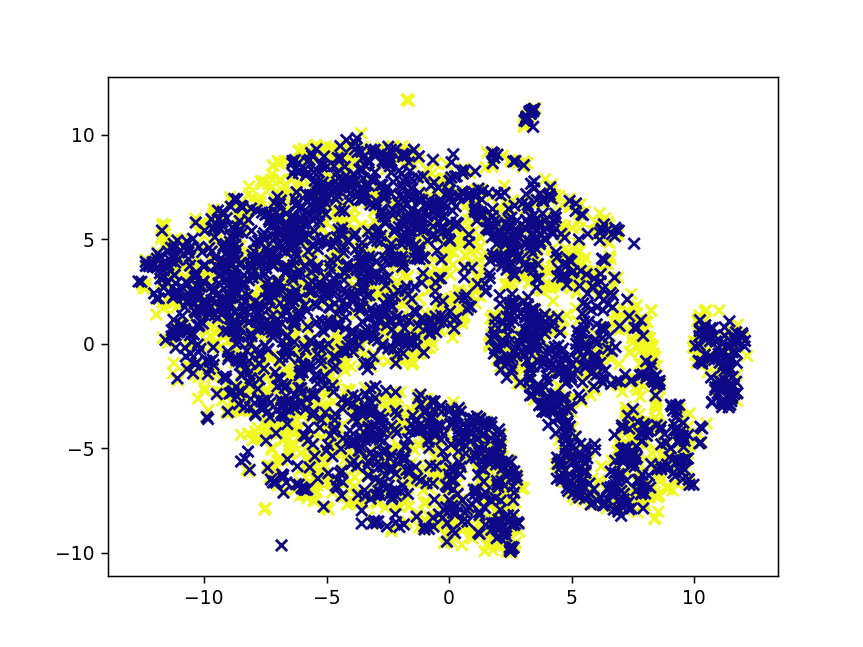

In [111]:
fig, ax = plt.subplots()
ax.scatter(*tsne.transpose(), c=ytr, cmap='plasma', marker='x')

# SVM

In [105]:
clf = svm.SVC(gamma=0.001, C=100.0) # Create classifier
clf.fit(x_train, y_train) # Fit classifier

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [89]:
clf.score(x_test, y_test)

0.50448000000000004

# NN

In [113]:
model = Sequential() # Create sequential model
# Add layers
model.add(Dense(64, input_dim=100)) # 32 units
model.add(Activation('relu')) # __/ --> zeros out negative values
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax')) # normalizes final results to probability distribution
model.compile(loss='categorical_crossentropy', # See notebook
             optimizer='sgd', # Stochastic gradient descent
             metrics=['accuracy'])

In [118]:
one_hot = to_categorical(y_tr, num_classes=2)
# Converts labels to one-hot encoding
model.fit(x_tr, one_hot, epochs = 10, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s - loss: 0.6981 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 2/10
20000/20000 [==============================] - 1s - loss: 0.6932 - acc: 0.4887 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 3/10
20000/20000 [==============================] - 1s - loss: 0.6932 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 4/10
20000/20000 [==============================] - 1s - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 5/10
20000/20000 [==============================] - 1s - loss: 0.6932 - acc: 0.5018 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 6/10
20000/20000 [==============================] - 1s - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 7/10
20000/20000 [==============================] - 1s - loss: 0.6932 - acc: 0.4966 - val_loss: 0.6931 - val_acc: 0.5018
Epoch 8/10
20000/20000 [==============================] - 1s -

In [119]:
test_one_hot = to_categorical(y_te, num_classes=2)
score, acc = model.evaluate(x_te, test_one_hot)
print()
print("Score:", score)
print("Accuracy:", acc)

24768/25000 [============================>.] - ETA: 0s
Score: 0.693129159756
Accuracy: 0.5
